In [495]:
import os
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

In [496]:
# Load raw cell image file paths only (do not load images)
raw_cells_dir = "../../data/digits/manual/raw/"
raw_cell_image_paths = []

# The images are stored directly in the raw directory, not in session subdirectories
for fname in os.listdir(raw_cells_dir):
    if fname.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
        img_path = os.path.join(raw_cells_dir, fname)
        raw_cell_image_paths.append(img_path)

print(f"Found {len(raw_cell_image_paths)} raw cell image files")


Found 1701 raw cell image files


In [497]:
# Load the actual raw cell images
raw_cell_images = []

for img_path in raw_cell_image_paths:
    img = cv.imread(img_path, cv.IMREAD_GRAYSCALE)
    if img is not None:
        raw_cell_images.append(img)
    else:
        print(f"Failed to load image: {img_path}")

print(f"Loaded {len(raw_cell_images)} raw cell images")


Loaded 1701 raw cell images


In [498]:
def remove_grid_borders(cell_image, debug=False):
    """
    Remove grid borders from a cell image by iteratively clearing black pixels from the edges,
    and return the cleaned image (digit only, background white).
    Steps:
    1. Darken the image by 30%.
    2. Blur the image.
    3. Binarize the image (background white, digit black) using Otsu's thresholding.
    4. For each edge, clear strips as long as the black percent is above threshold.
    5. Set those strips to white in the original image.
    6. Binarize the final cleaned image and return it (digit black, background white).
    """

    blur_ksize = 3
    max_val = 255
    black_percent_threshold = 0.35
    edge_strip_width = 3
    max_strips = 35

    img = cell_image.copy()
    # img = (img.astype(np.float32) * 0.7).clip(0, 255).astype(np.uint8)
    img_blur = cv.GaussianBlur(img, (17, 17), 0)
    _, img_bin = cv.threshold(img_blur, 0, max_val, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)
    img_bin = cv.bitwise_not(img_bin)

    h, w = img_bin.shape
    cleaned = cell_image.copy()

    for side in ['top', 'bottom', 'left', 'right']:
        for i in range(max_strips):
            if side == 'top':
                y1, y2 = i * edge_strip_width, min((i + 1) * edge_strip_width, h)
                x1, x2 = 0, w
            elif side == 'bottom':
                y1, y2 = h - (i + 1) * edge_strip_width, h - i * edge_strip_width
                y1 = max(y1, 0)
                x1, x2 = 0, w
            elif side == 'left':
                x1, x2 = i * edge_strip_width, min((i + 1) * edge_strip_width, w)
                y1, y2 = 0, h
            elif side == 'right':
                x1, x2 = w - (i + 1) * edge_strip_width, w - i * edge_strip_width
                x1 = max(x1, 0)
                y1, y2 = 0, h

            roi = img_bin[y1:y2, x1:x2]
            total = roi.size
            black = np.count_nonzero(roi == 0)
            black_percent = black / total if total > 0 else 0

            if black_percent > black_percent_threshold:
                cleaned[y1:y2, x1:x2] = 255
            else:
                break



    if debug:
        import matplotlib.pyplot as plt
        fig, axs = plt.subplots(1, 5, figsize=(20, 4))
        axs[0].imshow(cell_image, cmap='gray')
        axs[0].set_title('Original')
        axs[1].imshow(img_blur, cmap='gray')
        axs[1].set_title('Blurred')
        axs[2].imshow(img_bin, cmap='gray')
        axs[2].set_title('Binarized')
        axs[3].imshow(cleaned, cmap='gray')
        axs[3].set_title('Cleaned (White Strips)')
        for ax in axs:
            ax.axis('off')
        plt.show()

    return cleaned





In [499]:
def find_digit_in_cell(cell_image):
    """
    Finds the bounding rectangle of the largest contour (digit) in the cell image,
    crops to that region, and resizes back to the original cell_image size.
    """
    # Clean the image: binarize and dilate to connect digit parts
    _, cleaned = cv.threshold(cell_image, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)
    kernel = np.ones((5,5), np.uint8)
    dilation = cv.dilate(cleaned, kernel, iterations=1)
    # Find contours
    contours, _ = cv.findContours(dilation, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    if contours:
        largest = max(contours, key=cv.contourArea)
        x, y, w, h = cv.boundingRect(largest)
        # Crop to bounding box
        cropped = cell_image[y:y+h, x:x+w]
        # Resize back to original size
        resized = cv.resize(cropped, (cell_image.shape[1], cell_image.shape[0]), interpolation=cv.INTER_LINEAR)
        return resized
    else:
        # If no contour found, return the original image
        return cell_image


In [500]:
def process_cell(cell_image, debug=False):
    """
    Process cell image to remove grid borders, clean up the image, and sharpen the digit
    """
    no_border = remove_grid_borders(cell_image, debug=False)
    filtered_digit = find_digit_in_cell(no_border)

    binary = cv.GaussianBlur(filtered_digit, (3, 3), 0)
    thresh = cv.adaptiveThreshold(binary, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, 
                              cv.THRESH_BINARY, 11, 2)

    # Add a decent blur to the thresholded image to help smooth digit edges
    thresh = cv.GaussianBlur(thresh, (7, 7), 0)
    kernel = np.ones((3,3), np.uint8)
    binary = cv.dilate(thresh, kernel, iterations=1)
    thresh = cv.GaussianBlur(binary, (7, 7), 0)
    # # Simply sharpen digit
    # Invert colors
    binary = cv.bitwise_not(binary)
    # Erode the image
    kernel = np.ones((7,7), np.uint8)
    binary = cv.dilate(binary, kernel, iterations=1)
    kernel = np.ones((3,3), np.uint8)
    binary = cv.erode(binary, kernel, iterations=1)
    binary = cv.adaptiveThreshold(binary, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, 
                              cv.THRESH_BINARY, 11, 2)

    filtered_digit = binary

    return filtered_digit



In [501]:
# Simple function to test process_cell on a specific image
def test_process_cell(idx, debug=True):
    """Test process_cell function on a specific image, showing intermediate output."""
    if idx < len(raw_cell_images):
        raw_img = raw_cell_images[idx]
        print(f"Testing image {idx}")
        print(f"Raw image shape: {raw_img.shape}")
        print(f"Raw image range: {raw_img.min()} to {raw_img.max()}")

        # Show output of find_digit_in_cell
        digit_img = find_digit_in_cell(raw_img)
        
        # Process the image
        processed_img = process_cell(raw_img, debug=debug)
        
        # Display: raw image, digit image, processed image
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        
        # Raw image
        axes[0].imshow(raw_img, cmap='gray')
        axes[0].set_title(f'Raw Image {idx}\nSize: {raw_img.shape}')
        axes[0].axis('off')
        
        # Output of find_digit_in_cell
        axes[1].imshow(digit_img, cmap='gray')
        axes[1].set_title('find_digit_in_cell Output')
        axes[1].axis('off')
        
        # Processed image
        axes[2].imshow(processed_img, cmap='gray')
        axes[2].set_title(f'Processed Image {idx}\nSize: {processed_img.shape}')
        axes[2].axis('off')
        
        plt.tight_layout()
        plt.show()
        
        print(f"Processed image range: {processed_img.min()} to {processed_img.max()}")
        
        return processed_img
    else:
        print(f"Index {idx} out of range. Available images: 0-{len(raw_cell_images)-1}")
        return None


In [502]:
# Test the process_cell function
print(f"Loaded {len(raw_cell_images)} raw cell images")
print("Use test_process_cell(idx) to test on a specific image")
print("Example: test_process_cell(0, debug=True)")


Loaded 1701 raw cell images
Use test_process_cell(idx) to test on a specific image
Example: test_process_cell(0, debug=True)


Testing image 130
Raw image shape: (50, 50)
Raw image range: 71 to 201


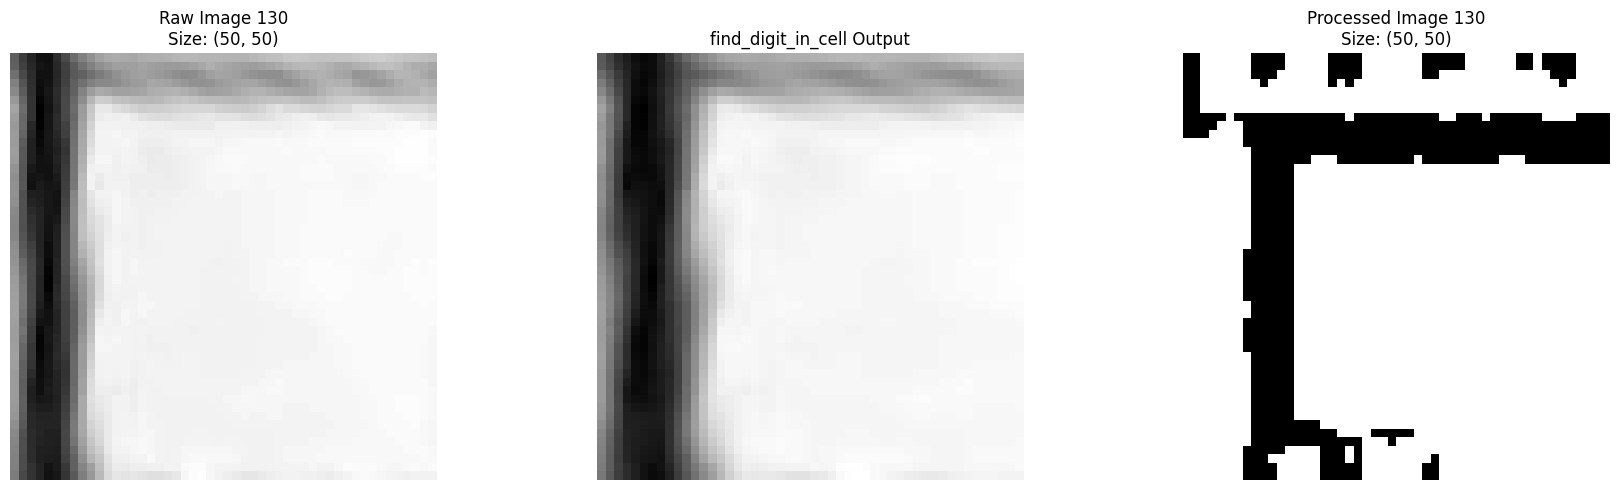

Processed image range: 0 to 255


array([[  0,   0, 255, ..., 255, 255, 255],
       [  0,   0, 255, ..., 255, 255, 255],
       [  0,   0, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], shape=(50, 50), dtype=uint8)

In [503]:
test_process_cell(130, debug=True)


Testing image 110
Raw image shape: (50, 50)
Raw image range: 89 to 221


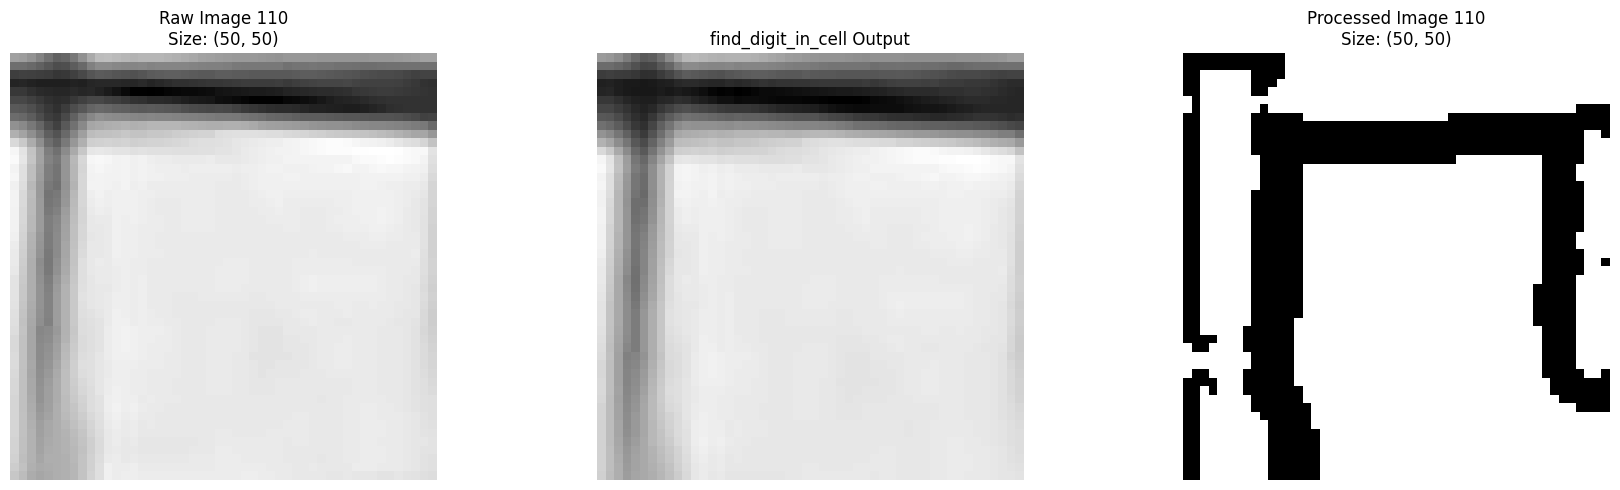

Processed image range: 0 to 255


array([[  0,   0,   0, ..., 255, 255, 255],
       [  0,   0,   0, ..., 255, 255, 255],
       [  0,   0, 255, ..., 255, 255, 255],
       ...,
       [  0,   0, 255, ..., 255, 255, 255],
       [  0,   0, 255, ..., 255, 255, 255],
       [  0,   0, 255, ..., 255, 255, 255]], shape=(50, 50), dtype=uint8)

In [504]:
test_process_cell(110, debug=True)

In [505]:
def show_remove_grid_borders(idx, debug=True):
    """
    Wrapper to show the result of remove_grid_borders for a given cell image index.
    """
    if idx < 0 or idx >= len(raw_cell_images):
        print(f"Index {idx} out of range. Available images: 0-{len(raw_cell_images)-1}")
        return None

    img = raw_cell_images[idx]
    cleaned = remove_grid_borders(img, debug=debug)
    plt.figure(figsize=(4, 4))
    plt.imshow(cleaned, cmap='gray')
    plt.title(f"remove_grid_borders Output (idx={idx})")
    plt.axis('off')
    plt.show()
    return cleaned


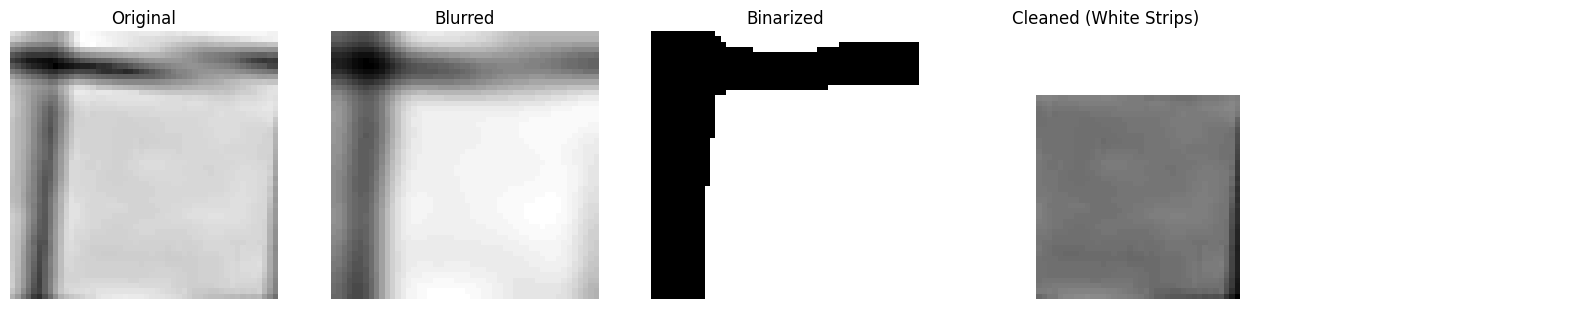

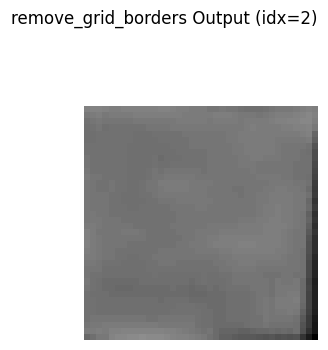

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 199, 191, 179],
       [255, 255, 255, ..., 198, 188, 179],
       [255, 255, 255, ..., 189, 181, 172]], shape=(50, 50), dtype=uint8)

In [506]:
show_remove_grid_borders(2)

In [507]:
def find_cell_lines(img, debug=True):
    """
    Detects lines in a cell image using HoughLinesP and shows the detected lines.
    Returns the image with lines drawn and the list of lines.
    """
    # Convert to grayscale if needed
    if len(img.shape) == 3:
        gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    else:
        gray = img.copy()
    # Increase contrast using histogram equalization
    # No contrast enhancement (less contrast)
    # gray = cv.equalizeHist(gray)

    # Edge detection
    edges = cv.Canny(gray, 50, 150, apertureSize=3)

    # Hough Line Transform (probabilistic)
    lines = cv.HoughLinesP(edges, 1, np.pi / 180, threshold=20, minLineLength=10, maxLineGap=5)

    # Prepare image for drawing
    img_lines = cv.cvtColor(gray, cv.COLOR_GRAY2BGR)

    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv.line(img_lines, (x1, y1), (x2, y2), (0, 0, 255), 2)

    if debug:
        plt.figure(figsize=(8, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(gray, cmap='gray')
        plt.title('Input')
        plt.axis('off')
        plt.subplot(1, 2, 2)
        plt.imshow(img_lines)
        plt.title('Detected Lines')
        plt.axis('off')
        plt.show()

    return img_lines, lines


In [508]:
def show_cell_lines(idx, debug=True):
    """
    Wrapper for find_cell_lines that takes a cell index, runs line detection, and shows the result.
    """
    img = raw_cell_images[idx]
    img_lines, lines = find_cell_lines(img, debug=debug)
    return img_lines


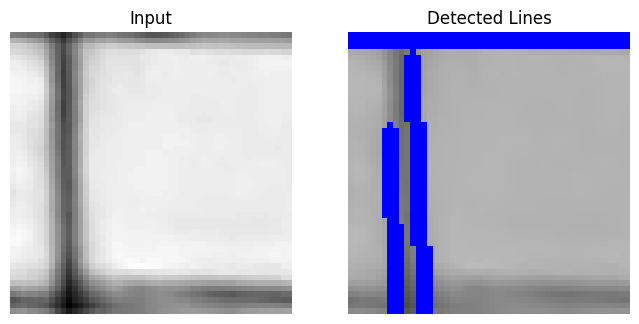

array([[[  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255],
        ...,
        [  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255]],

       [[  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255],
        ...,
        [  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255]],

       [[  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255],
        ...,
        [  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255]],

       ...,

       [[113, 113, 113],
        [116, 116, 116],
        [120, 120, 120],
        ...,
        [118, 118, 118],
        [116, 116, 116],
        [116, 116, 116]],

       [[120, 120, 120],
        [122, 122, 122],
        [123, 123, 123],
        ...,
        [132, 132, 132],
        [131, 131, 131],
        [131, 131, 131]],

       [[137, 137, 137],
        [139, 139, 139],
        [140, 140, 140],
        ...,
        [145, 145, 145],
        [146, 146, 146],
        [146, 146, 146]]

In [510]:
show_cell_lines(55)

In [511]:
def find_foreground_watershed(img, debug=False):
    """
    Applies watershed algorithm to find the foreground in the image.
    Returns a mask where the foreground is marked as 255, background as 0.
    """
    # Convert to grayscale if needed
    if len(img.shape) == 3:
        gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    else:
        gray = img.copy()

    # Noise removal
    blur = cv.GaussianBlur(gray, (3, 3), 0)
    ret, thresh = cv.threshold(blur, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)

    # Morphological opening to remove small noise
    kernel = np.ones((3,3), np.uint8)
    opening = cv.morphologyEx(thresh, cv.MORPH_OPEN, kernel, iterations=2)

    # Sure background area
    sure_bg = cv.dilate(opening, kernel, iterations=3)

    # Sure foreground area
    dist_transform = cv.distanceTransform(opening, cv.DIST_L2, 5)
    ret, sure_fg = cv.threshold(dist_transform, 0.5 * dist_transform.max(), 255, 0)
    sure_fg = np.uint8(sure_fg)

    # Unknown region
    unknown = cv.subtract(sure_bg, sure_fg)

    # Marker labelling
    ret, markers = cv.connectedComponents(sure_fg)
    # Add one to all labels so that sure background is not 0, but 1
    markers = markers + 1
    # Mark the unknown region with zero
    markers[unknown == 255] = 0

    # Watershed expects a 3-channel image
    if len(img.shape) == 2:
        img_color = cv.cvtColor(img, cv.COLOR_GRAY2BGR)
    else:
        img_color = img.copy()

    cv.watershed(img_color, markers)

    # Foreground mask: regions marked with >1 (not background or boundary)
    foreground_mask = np.zeros_like(gray, dtype=np.uint8)
    foreground_mask[markers > 1] = 255

    if debug:
        import matplotlib.pyplot as plt
        fig, axs = plt.subplots(1, 4, figsize=(20, 5))
        axs[0].imshow(gray, cmap='gray')
        axs[0].set_title('Gray')
        axs[1].imshow(opening, cmap='gray')
        axs[1].set_title('Opening')
        axs[2].imshow(sure_fg, cmap='gray')
        axs[2].set_title('Sure Foreground')
        axs[3].imshow(foreground_mask, cmap='gray')
        axs[3].set_title('Watershed Foreground')
        for ax in axs:
            ax.axis('off')
        plt.show()

    return foreground_mask


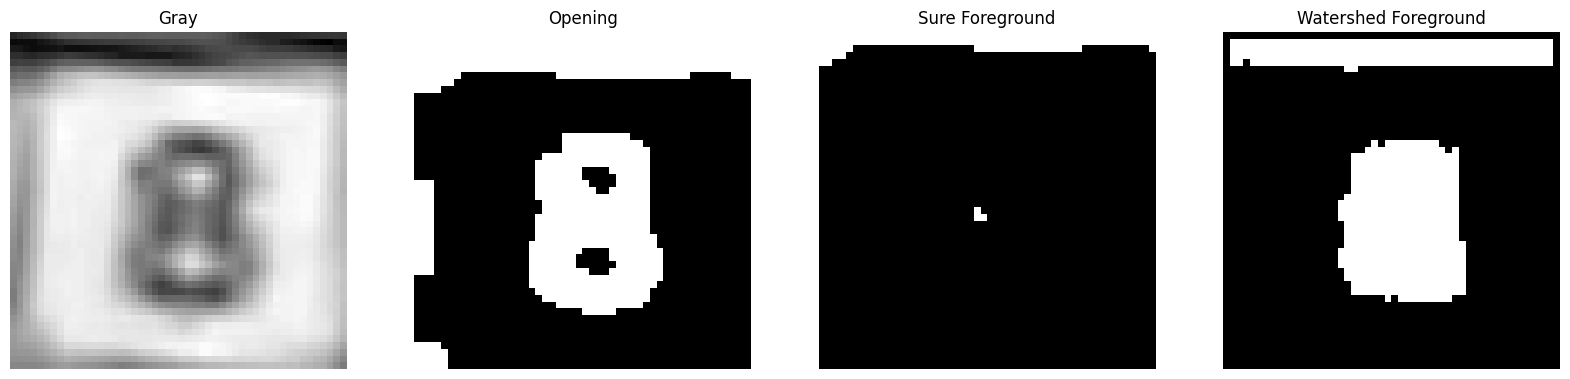

array([[  0,   0,   0, ...,   0,   0,   0],
       [  0, 255, 255, ..., 255, 255,   0],
       [  0, 255, 255, ..., 255, 255,   0],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], shape=(50, 50), dtype=uint8)

In [517]:
idx = 75
img = raw_cell_images[idx]
find_foreground_watershed(img, debug=True)